This notebook simply reads and displays the available shapefiles for visual validation.

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from enum import Enum

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
class AnalysisConfig:
    def __init__(self, shapefile_path='', stations_path='', trip_count_matrix_path=''):
        self.shapefile_path = shapefile_path
        self.stations_path = stations_path
        self.trip_count_matrix_path = trip_count_matrix_path

In [3]:
MATRIX_DIR = '../data/exports/adjacency_matrix'
SHAPEFILE_DIR = '../data/shapefiles/zipcodes'
STATIONS_DIR = '../data/exports'

config_sf = AnalysisConfig(
    shapefile_path = '{}/san_francisco.shp'.format(SHAPEFILE_DIR),
    stations_path = '{}/SF_ele_single station.csv'.format(STATIONS_DIR),
    trip_count_matrix_path = '{}/trip_count_sf.csv'.format(MATRIX_DIR),
)

config_dc = AnalysisConfig(
    shapefile_path = '{}/washington_dc.shp'.format(SHAPEFILE_DIR),
    stations_path = '{}/DC_ele_single station.csv'.format(STATIONS_DIR),
    trip_count_matrix_path = '{}/trip_count_dc.csv'.format(MATRIX_DIR),
)

In [4]:
config = config_sf

In [5]:
def load_gdfs(config):
    zips_gdf = gpd.read_file(config.shapefile_path)
    stations_df = pd.read_csv(config.stations_path)
    stations_gdf = gpd.GeoDataFrame(
        stations_df,
        geometry=gpd.points_from_xy(stations_df['lng'],
                                    stations_df['lat'])).set_crs('EPSG:4326')
    return (zips_gdf, stations_gdf)

In [6]:
def get_flow_df(matrix_path):
    matrix = pd.read_csv(matrix_path).set_index('station_id')
    in_counts = matrix.sum(numeric_only=True)
    out_counts = matrix.sum(axis=1)
    matrix['in'] = in_counts
    matrix['out'] = out_counts
    matrix['diff'] = in_counts - out_counts
    return matrix[['in', 'out', 'diff']]

def get_normalized_column(df, column):
    column_min = df[column].min()
    return (df[column] - column_min) / (df[column].max() - column_min)

def normalize_flow_df(df):
    normalized_df = df.copy()
    normalized_df['in'] = get_normalized_column(df, 'in')
    normalized_df['out'] = get_normalized_column(df, 'out')
    normalized_df['diff'] = get_normalized_column(df, 'diff')
    return normalized_df

trip_flow_df = get_flow_df(config_sf.trip_count_matrix_path)
display(trip_flow_df)

,in,out,diff
station_id,,,
SF-M26,557,488,69
SF-M25,1723,1704,19
SF-M26-2,2466,2224,242
SF-L27,961,975,-14
SF-K26,3164,2580,584
...,...,...,...
SF-Z16,164,139,25
SF-Y14,311,367,-56
SF-X14,89,128,-39


In [7]:
zips_gdf, stations_gdf, = load_gdfs(config_sf)
stations_flow_gdf = pd.merge(stations_gdf, trip_flow_df, on='station_id')

In [9]:
CRS_PLOT = 'EPSG:4326'

def plot_stations(zips_gdf, stations_gdf, column, title):
    fig, ax = plt.subplots(figsize=(15, 15))
    zips_gdf.to_crs({'init': CRS_PLOT}).plot(ax=ax, color='grey')
    norm = matplotlib.colors.Normalize()
    stations_gdf.to_crs({
        'init': CRS_PLOT
    }).plot(ax=ax,
            column=column,
            norm=norm,
            legend=True,
            cmap='coolwarm',
            edgecolors='black')
    ax.set_title(title)
    plt.show()

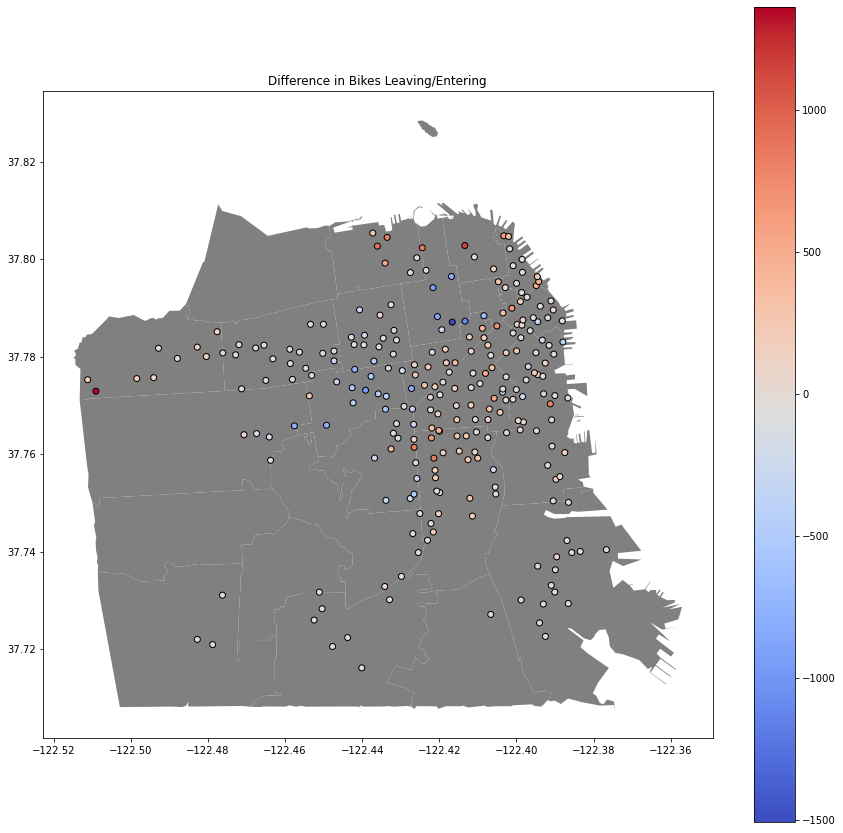

In [10]:
plot_stations(zips_gdf, stations_flow_gdf, 'diff', 'Difference in Bikes Leaving/Entering')

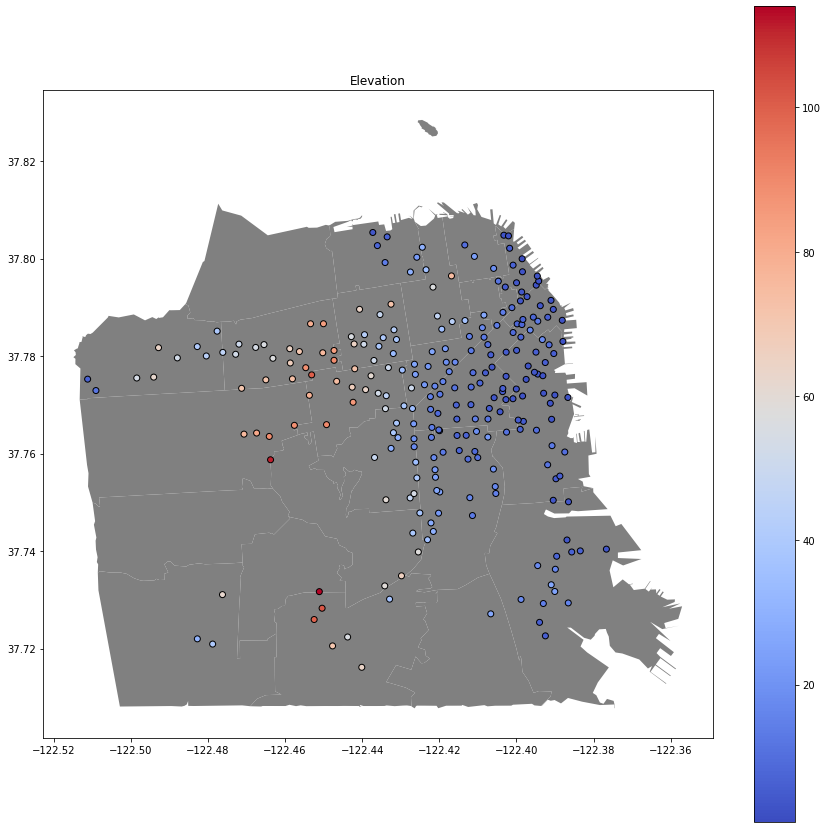

In [11]:
plot_stations(zips_gdf, stations_flow_gdf, 'elevation', 'Elevation')